# Autoencoder Convolucional SSA - Two layers HH

Continuamos el estudio de SSA a primer orden, entrenamos un modelo convolucional utilizando imágenes de gráficos polares de la sección eficaz - $\sigma(\hat{k}_x, \hat{k}_y)$ -  generados por un modelo de dos capas rugosas bajo la aproximación SSA. Esta vez dejamos fija la geometría incidente. La potencia dispersada se calcula utilizando la aproximación SPM de primer orden, en el canal HH.

In [8]:
import numpy as np
from numpy import pi
from matplotlib import pyplot as plt

import two_rough_layers 

# Parámetros fijos
realizations = 30000

# Generamos los parámetros que vamos a variar aleatoriamente
k0 = 2*pi/.25
d = np.linspace(.5, 1.5, 50)
ep1, ep2 = np.arange(3, 53), np.arange(3, 53)
s1, s2 = np.linspace(.005, .025, 50), np.linspace(.005, .025, 50)
l1, l2 = np.linspace(.05, .25, 50), np.linspace(.05, .25, 50)
theta_i, phi_i = 45*np.pi/180, 0*np.pi/180

# Parámetros para recorrer
theta, phi = np.linspace(1e-5, 89, 30)*np.pi / \
    180, np.linspace(0, 360, 30)*np.pi/180
THETA, PHI = np.meshgrid(theta, phi)

kx = np.sin(THETA)*np.cos(PHI)
ky = np.sin(THETA)*np.sin(PHI)

# Sampleo y recorro: generamos un vector aleatorio que contenga los índices de los argumentos
rng = np.random.default_rng()
sigma = np.zeros((realizations, PHI.shape[0], PHI.shape[1]))

# Defino una función para normalizar los datos
def MinMax(tensor):
    return (tensor - np.min(tensor)) / (np.max(tensor) - np.min(tensor))

for i in range(realizations):
    # Genero una tira de indices aleatorios
    index = rng.integers(50, size=7)

    # Armo una tupla con los argumentos de S01
    args = (k0, THETA, PHI,
            theta_i, phi_i,
            ep1[index[0]], ep2[index[1]],
            s1[index[2]], l1[index[3]],
            s2[index[4]], l2[index[5]],
            d[index[6]])

    # Calculo la sección eficaz y agrego ruido
    s_O1 = two_rough_layers.suma_O1(*args)

    # h-pol
    s_hh = s_O1[1, 1]
    s_hh_noise = s_hh + rng.normal(0, .03*np.mean(s_hh), size=PHI.shape)

    # Guardo los resultados en un tensor: primero apilo los tres canales (stack)
    # Cuenta cantidad de NaNs
    cond = np.count_nonzero(np.isnan(s_hh_noise))
    if cond == 0:
        sigma[i, :, :] = s_hh_noise
    else:
        raise ValueError(f'Input contains NaN, infinity or a value too large for {s_hh_noise.dtype}')

# Chequeo el tamaño de los datos
shape = sigma.shape
print(f'Tamaños de los datos originales: {shape}')

Tamaños de los datos originales: (30000, 30, 30)


Separo en grupos de testeo y entrenamiento.

In [9]:
from sklearn.model_selection import train_test_split

# Chequeo que no haya NaNs
print(f'Cantidad de NaNs en sigma: {np.count_nonzero(np.isnan(sigma))}')

# Separo en conjuntos de entrenamiento y testeo
sigma_train, sigma_test = train_test_split(sigma, test_size=.3)

print(f'Tamaño de los datos de entrenamiento: {sigma_train.shape}')
print(f'Tamaño de los datos de testeo: {sigma_test.shape}')

Cantidad de NaNs en sigma: 0
Tamaño de los datos de entrenamiento: (21000, 30, 30)
Tamaño de los datos de testeo: (9000, 30, 30)


### Transformo los datos a DB y miro su distribución

In [173]:
# Normalizo MinMax
sigma_train = MinMax(sigma_train)
sigma_test = MinMax(sigma_test)

# Como voy a tomar logaritmo, reemplazo los valores que son cero
sigma_train = np.where(sigma_train!=0.0, sigma_train, 1e-7)
sigma_test = np.where(sigma_test!=0.0, sigma_test, 1e-7)

print(np.min(sigma_train))
print(np.min(sigma_test))

1e-07
1e-07


Min(log_sigma_train) = 0.0
Max(log_sigma_train) = 1.0
Min(log_sigma_test) = 0.0
Max(log_sigma_test) = 1.0


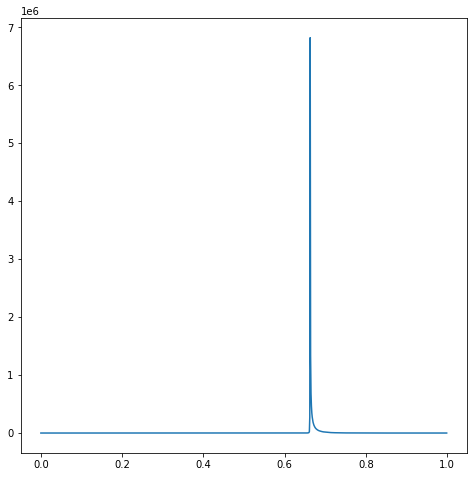

In [174]:
# Armo un histograma para todo el dataset
n_bins = 1000
count = np.zeros(n_bins)

# Paso a db y normalizo nuevamente los datos de entrenamiento
log_sigma_train = MinMax(10*np.log10(sigma_train))
print((f'Min(log_sigma_train) = {np.min(log_sigma_train)}\n'
f'Max(log_sigma_train) = {np.max(log_sigma_train)}'))

# Paso a db y normalizo nuevamente los datos de testeo
log_sigma_test = MinMax(10*np.log10(sigma_test))
print((f'Min(log_sigma_test) = {np.min(log_sigma_test)}\n'
f'Max(log_sigma_test) = {np.max(log_sigma_test)}'))

# Miramos la distribucion de los nuevos datos de entrenamiento
for img in log_sigma_train:
    hist, bins = np.histogram(img, range=(0,1), bins=n_bins)
    count += hist

fig, ax = plt.subplots(1, 1, figsize=(8,8))
ax.plot(bins[:-1], count)

## Probemos estandarizando los datos

In [10]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Agrego una dimensión extra al final 
sigma_train, sigma_test = np.expand_dims(sigma_train, axis=-1), np.expand_dims(sigma_test, axis=-1)
print(f'Tamaño de los datos de entrenamiento: {sigma_train.shape}')
print(f'Tamaño de los datos de testeo: {sigma_test.shape}')

# Inicio un objeto ImageDataGenerator estandarizado por set
datagen = ImageDataGenerator(featurewise_center=True, featurewise_std_normalization=True)

# Ajusto utilizando el training set
datagen.fit(sigma_train)

# Obtengo los batches para ambos sets
standard_train = datagen.standardize(sigma_train)
standard_test = datagen.standardize(sigma_test)

print(f'Train Mean: {standard_train.mean():.4f} - Train std: {standard_train.std():.4f}' )
print(f'Test Mean: {standard_test.mean():.4f} - Test std: {standard_test.std():.4f}' )

Tamaño de los datos de entrenamiento: (21000, 30, 30, 1)
Tamaño de los datos de testeo: (9000, 30, 30, 1)
Train Mean: 0.0000 - Train std: 0.9999
Test Mean: 0.0023 - Test std: 1.0913


## Visualizo las soluciones generadas

(-1.0, 1.0)

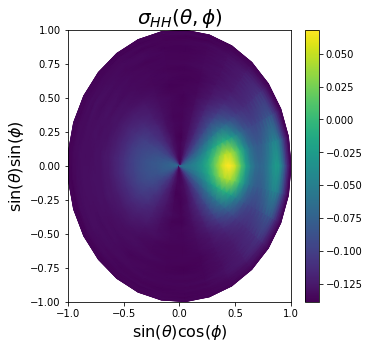

In [12]:
# Elijo una imagen al azar
index = rng.integers(sigma_train.shape[0]) 
img = sigma_train[index, :, :, 0]

fig = plt.figure(figsize=(5, 5))
ax = plt.subplot()
c = ax.pcolormesh(kx, ky, img,
                  shading = 'gouraud' )
plt.title(r'$\sigma_{HH}(\theta,\phi)$', fontsize = 20)
plt.xlabel(r"$\sin(\theta)\cos(\phi)$", fontsize = 16)
plt.ylabel(r"$\sin(\theta)\sin(\phi)$", fontsize = 16)
fig.colorbar(c, ax=ax)
plt.xlim((-1,1))
plt.ylim((-1,1))


## Preparo los datos y defino el Autoencoder

Visualizo los elementos del conjuto de entrenamiento

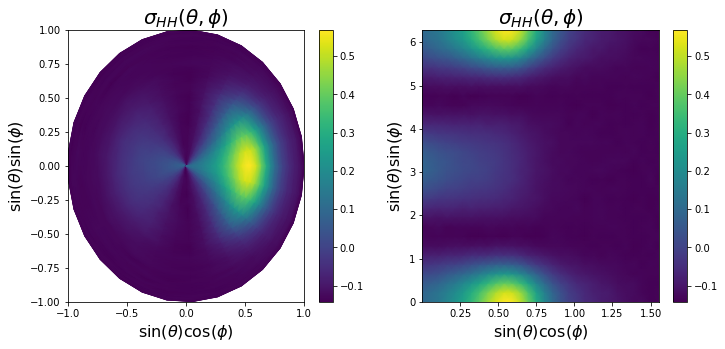

In [14]:
index = rng.integers(sigma_train.shape[0]) 
img = sigma_train[index, :, :, 0]


fig = plt.figure(figsize=(18, 5))
# Canal HH
ax = plt.subplot(1, 3, 1)
c = ax.pcolormesh(kx, ky, img,
                  shading = 'gouraud' )
plt.title(r'$\sigma_{HH}(\theta,\phi)$', fontsize = 20)
plt.xlabel(r"$\sin(\theta)\cos(\phi)$", fontsize = 16)
plt.ylabel(r"$\sin(\theta)\sin(\phi)$", fontsize = 16)
fig.colorbar(c, ax=ax)
plt.xlim((-1,1))
plt.ylim((-1,1))

# grafico cartesiano
ax = plt.subplot(1, 3, 2)
c = ax.pcolormesh(THETA, PHI, img,
                  shading = 'gouraud' )
plt.title(r'$\sigma_{HH}(\theta,\phi)$', fontsize = 20)
plt.xlabel(r"$\sin(\theta)\cos(\phi)$", fontsize = 16)
plt.ylabel(r"$\sin(\theta)\sin(\phi)$", fontsize = 16)
fig.colorbar(c, ax=ax)


In [23]:
from tensorflow.keras.models import Model
from tensorflow.keras import layers, losses

tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)


class ConvAutoencoder(Model):
    
    def __init__(self, latent_dim):
        super().__init__()
        self.latent_dim = latent_dim
        self.encoder = tf.keras.Sequential([layers.InputLayer(input_shape = (30,30,1)), 
                                            layers.Conv2D(4, (7, 7), strides=1, activation = 'relu'),
                                            layers.MaxPooling2D((2, 2), strides=1, padding = 'same'),
                                            
                                            layers.Conv2D(8, (5, 5), strides=1, activation = 'relu'),
                                            layers.MaxPooling2D((2, 2), strides=1, padding = 'same'),
                                            
                                            layers.Conv2D(8, (3, 3), strides=2, activation = 'relu'),
                                            layers.MaxPooling2D((2, 2), strides=1, padding = 'same'),
                                            
                                            layers.Flatten(),
                                            
                                            layers.Dense(units=9*9*8, activation='relu', 
                                            kernel_regularizer=tf.keras.regularizers.l2(l=0.1)),
                                            layers.Dropout(.2),
                                            
                                            layers.Dense(units=256, activation='relu', 
                                            kernel_regularizer=tf.keras.regularizers.l2(l=0.1)),
                                            layers.Dropout(.2),
                                            
                                            layers.Dense(units=64, activation='relu', 
                                            kernel_regularizer=tf.keras.regularizers.l2(l=0.1)),
                                            layers.Dropout(.2),

                                            layers.Dense(latent_dim, activation = 'linear')])
      
        
        self.decoder = tf.keras.Sequential([layers.InputLayer(input_shape=(latent_dim,)),

                                            layers.Dense(units=64, activation='relu', 
                                            kernel_regularizer=tf.keras.regularizers.l2(l=0.1)),
                                            layers.Dropout(.2),

                                            layers.Dense(units=256, activation='relu', 
                                            kernel_regularizer=tf.keras.regularizers.l2(l=0.1)),
                                            layers.Dropout(.2),

                                            layers.Dense(units=9*9*8, activation='relu', 
                                            kernel_regularizer=tf.keras.regularizers.l2(l=0.1)),
                                            layers.Dropout(.2),
                                            
                                            layers.Reshape(target_shape=(9,9,8)),
                                            
                                            layers.Conv2DTranspose(8, (4, 4), strides=2, activation="relu"),
                                            
                                            layers.Conv2DTranspose(8, (5, 5), strides=1, activation="relu"),

                                            layers.Conv2DTranspose(4, (7, 7), strides=1, activation='relu'),

                                            layers.Conv2D(1, (3, 3), activation="sigmoid", padding="same")])

    def call(self, X):
        encoded = self.encoder(X)
        decoded = self.decoder(encoded)
        return decoded
  
    def summary(self):
        print(self.encoder.summary())
        print(self.decoder.summary())

In [178]:
# import tensorflow as tf
# from tensorflow.keras.models import Model
# from tensorflow.keras import layers, losses

# tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

# class ConvAutoencoder(Model):
    
#     def __init__(self, latent_dim):
#         super().__init__()
#         self.latent_dim = latent_dim
#         self.encoder = tf.keras.Sequential([layers.InputLayer(input_shape = (45,90,1)), 
#                                             layers.Conv2D(4, (7, 7), strides=1, activation = 'relu'),
#                                             layers.MaxPooling2D((2, 2), strides=1, padding = 'same'),
                                            
#                                             layers.Conv2D(8, (5, 5), strides=1, activation = 'relu'),
#                                             layers.MaxPooling2D((2, 2), strides=1, padding = 'same'),
                                            
#                                             layers.Conv2D(8, (3, 3), strides=2, activation = 'relu'),
#                                             layers.MaxPooling2D((2, 2), strides=1, padding = 'same'),
                                            
#                                             layers.Flatten(),
                                            
#                                             layers.Dense(units=17*39*8, activation='relu'),
#                                             layers.Dropout(.2),

#                                             layers.Dense(units=256, activation='relu'),
#                                             layers.Dropout(.2),

#                                             layers.Dense(units=64, activation='relu'),
#                                             layers.Dropout(.2),

#                                             layers.Dense(latent_dim, activation = 'linear')])
      
        
#         self.decoder = tf.keras.Sequential([layers.InputLayer(input_shape=(latent_dim,)),

#                                             layers.Dense(units=64, activation='relu'),
#                                             layers.Dropout(.2),
                                            
#                                             layers.Dense(units=256, activation='relu'),
#                                             layers.Dropout(.2),

#                                             layers.Dense(units=17*39*8, activation='relu'),
#                                             layers.Dropout(.2),
                                            
#                                             layers.Reshape(target_shape=(17,39,8)),
                                            
#                                             layers.Conv2DTranspose(8, (3, 4), strides=2, activation="relu"),
                                            
#                                             layers.Conv2DTranspose(8, (5, 5), strides=1, activation="relu"),

#                                             layers.Conv2DTranspose(4, (7, 7), strides=1, activation='relu'),

#                                             layers.Conv2D(1, (3, 3), activation="sigmoid", padding="same")])

#     def call(self, X):
#         encoded = self.encoder(X)
#         decoded = self.decoder(encoded)
#         return decoded
  
#     def summary(self):
#         print(self.encoder.summary())
#         print(self.decoder.summary())

In [24]:
autoencoder = ConvAutoencoder(8)
autoencoder.encoder.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 24, 24, 4)         200       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 24, 24, 4)         0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 20, 20, 8)         808       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 20, 20, 8)         0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 9, 9, 8)           584       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 9, 9, 8)           0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 648)              

In [25]:
autoencoder.decoder.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_11 (Dense)             (None, 64)                576       
_________________________________________________________________
dropout_9 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_12 (Dense)             (None, 256)               16640     
_________________________________________________________________
dropout_10 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_13 (Dense)             (None, 648)               166536    
_________________________________________________________________
dropout_11 (Dropout)         (None, 648)               0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 9, 9, 8)          

In [181]:
# Extiendo las dimensiones de sigma para ingresar al modelo
sigma_train, sigma_test = np.expand_dims(log_sigma_train, axis=-1), np.expand_dims(log_sigma_test, axis=-1)
print(f'Tamaño de los datos de entrenamiento: {sigma_train.shape}')
print(f'Tamaño de los datos de testeo: {sigma_test.shape}')

# Guardo el grupo de testeo para usar más tarde
# folder = os.getcwd().split('/')[:-2]
# file_name = "results/SSA_tl_test_set"

# file_path = os.path.join("/".join(folder), file_name)
# np.save(file_path, sigma_test)

Tamaño de los datos de entrenamiento: (14000, 30, 30, 1)
Tamaño de los datos de testeo: (6000, 30, 30, 1)


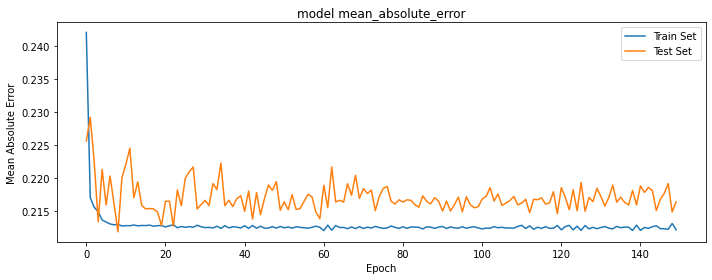

In [26]:
autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError(),
                    metrics=['mean_absolute_error', 'mean_squared_error'])

history = autoencoder.fit(sigma_train, sigma_train,
            epochs = 150,
            batch_size = 32,
            verbose = 0,
            validation_data=(sigma_test, sigma_test))

# Visualizo el entrenamiento
plt.figure(figsize = (10,4))
plt.subplot(1,1,1)
plt.plot(history.history['mean_absolute_error'])
plt.plot(history.history['val_mean_absolute_error'])
plt.title('model mean_absolute_error')
plt.ylabel('Mean Absolute Error')
plt.xlabel('Epoch')
plt.legend(['Train Set', 'Test Set'])
plt.tight_layout()
plt.show()


In [9]:
# Guardamos los pesos de la red entrenada
import os
file_name = 'results/weights_lat_3_ssa_two_layer_HH.h5'
folder = os.getcwd().split('/')[:-2]
weights_path = os.path.join('/'.join(folder), file_name)
autoencoder.save_weights(weights_path)

# Visualizamos los resultados 

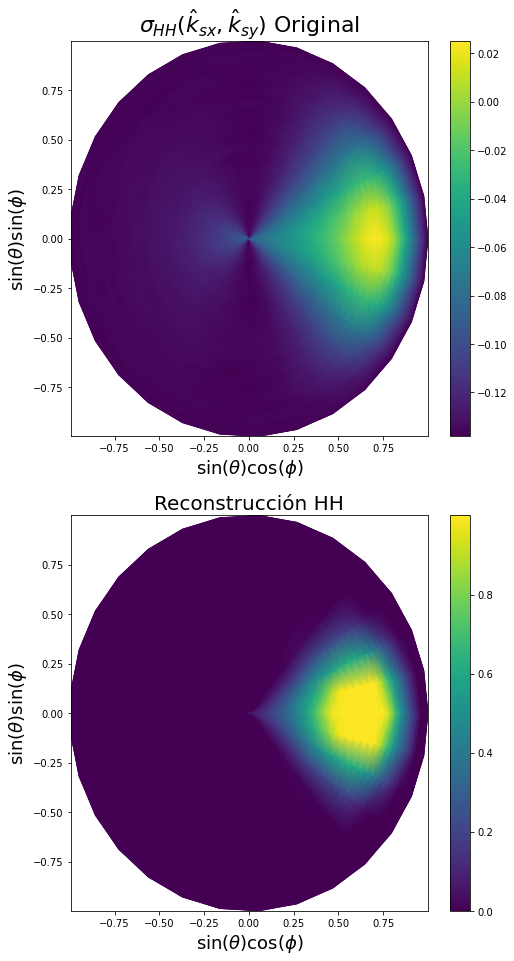

In [27]:
# Genero y decodifico imagenes de testeo
encoded_imgs = autoencoder.encoder(sigma_test).numpy()
decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()

n = 1
pol = {0: "HH", 1: "HV", 2: "VV"}
index = rng.integers(sigma_test.shape[0])

fig = plt.figure(figsize=(8, 16)) 
for i in range(n):
    # Imagen original
    s = sigma_test[index, :, :, 0]
    s_min, s_max = s.min(), s.max()
    ax = plt.subplot(2, n, i + 1)
    c1 = ax.pcolormesh(kx, ky, s, shading = 'gouraud')
    plt.title(f"$\sigma_{{{pol[i]}}}(\hat{{k}}_{{sx}},\hat{{k}}_{{sy}})$ Original", fontsize = 22)
    plt.xlabel(r"$\sin(\theta)\cos(\phi)$", fontsize = 18)
    plt.ylabel(r"$\sin(\theta)\sin(\phi)$", fontsize = 18)
    ax.axis([kx.min(), kx.max(), ky.min(), ky.max()])
    fig.colorbar(c1, ax=ax)

    # Imagen reconstruida
    s_recons = decoded_imgs[index, :, :, 0]
    s_min, s_max = s_recons.min(), s_recons.max()
    ax = plt.subplot(2, n, i + 1 + n)
    c2 = ax.pcolormesh(kx, ky, s_recons, vmin=s_min,
                       vmax=s_max, shading = 'gouraud')
    plt.title(f"Reconstrucción {pol[i]}", fontsize = 20)
    plt.xlabel(r"$\sin(\theta)\cos(\phi)$", fontsize = 18)
    plt.ylabel(r"$\sin(\theta)\sin(\phi)$", fontsize = 18)
    ax.axis([kx.min(), kx.max(), ky.min(), ky.max()])
    fig.colorbar(c2, ax=ax)
plt.show()


### Pruebo con KFold Cross Validation


In [170]:
from sklearn.model_selection import KFold

def log_mapping(tensor):
    """Mapea la distribución de los datos
    a una distribución uniforme"""
    
    # Hago un primer reescaleado
    scaled_tensor = MinMax(tensor)

    # Paso a una escala en DB
    scaled_tensor = np.where(scaled_tensor!=0.0, scaled_tensor, 1e-7)

    return MinMax(10*np.log10(scaled_tensor))


kfold_cv = KFold(n_splits=5)
mse = list()
mae = list()

for train_fold, test_fold in kfold_cv.split(sigma):
    # Transformo los datos
    sigma_train = log_mapping(train_fold)
    sigma_test = log_mapping(test_fold)

    # Agrego una dimensión más para ingresar a la red
    sigma_train = np.expand_dims(sigma_train, axis=-1)
    sigma_test = np.expand_dims(sigma_test, axis=-1)

    # Entreno el modelo
    autoencoder = ConvAutoencoder(3)
    autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError(),
                    metrics=['mean_absolute_error', 'mean_squared_error'])
    history = autoencoder.fit(sigma_train, sigma_train,
            epochs = 100,
            batch_size = 32,
            verbose = 0,
            validation_data=(sigma_test, sigma_test))

    # Guardo los datos 
    mse.append(history.history['val_mean_absolute_error'])
    mae.append(history.history['val_mean_squared_error'])
     
    # Elimino el modelo de memoria
    tf.keras.backend.clear_session()
    del autoencoder      

mse = np.vstack(mse)
mae = np.vstack(mae)      

ValueError: in user code:

    /home/tele/proyects/tesis/lib/python3.8/site-packages/keras/engine/training.py:853 train_function  *
        return step_function(self, iterator)
    /tmp/ipykernel_17807/2503157997.py:56 call  *
        encoded = self.encoder(X)
    /home/tele/proyects/tesis/lib/python3.8/site-packages/keras/engine/base_layer.py:1020 __call__  **
        input_spec.assert_input_compatibility(self.input_spec, inputs, self.name)
    /home/tele/proyects/tesis/lib/python3.8/site-packages/keras/engine/input_spec.py:229 assert_input_compatibility
        raise ValueError('Input ' + str(input_index) + ' of layer ' +

    ValueError: Input 0 of layer sequential_30 is incompatible with the layer: : expected min_ndim=4, found ndim=2. Full shape received: (32, 1)


## Variamos la dimensión del Espacio Latente

In [25]:
# Antes de comenzar limpiamos los pesos del modelo y el grafo de TF
tf.keras.backend.clear_session()
del autoencoder

In [16]:
# Entreno varios autoencoders con distinta dim en espacio latente
min_abs_error, min_sqr_error  = [], []
avg_abs_error, avg_sqr_error = [], []

for lat_dim in range(1, 16):
  autoencoder = ConvAutoencoder(lat_dim)
  autoencoder.compile(optimizer = 'adam', loss = losses.MeanSquaredError(),
                    metrics = ['mean_absolute_error', 'mean_squared_error'])

  # Entreno el modelo
  history = autoencoder.fit(sigma_train, sigma_train,
            epochs = 200,
            batch_size = 30,
            verbose = 0,
            validation_data=(sigma_test, sigma_test))
  
  error_abs = np.array(history.history['val_mean_absolute_error'])
  error_sqr = np.array(history.history['val_mean_squared_error'])

  # Valor mínimo del error
  min_abs_error.append(error_abs.min())
  min_sqr_error.append(error_sqr.min())

  # Valor promedio del error en los ultimos 10 epochs
  avg_abs_error.append(np.mean(error_abs[-50:]))
  avg_sqr_error.append(np.mean(error_sqr[-50:]))

  tf.keras.backend.clear_session()

In [27]:
error_abs = np.array(history.history['val_mean_absolute_error'])
error_sqr = np.array(history.history['val_mean_squared_error'])

# Valor mínimo del error
min_abs_error[13] = error_abs.min()
min_sqr_error[13] = error_sqr.min()

# Valor promedio del error en los ultimos 10 epochs
avg_abs_error[13] = np.mean(error_abs[-50:])
avg_sqr_error[13] = np.mean(error_sqr[-50:])

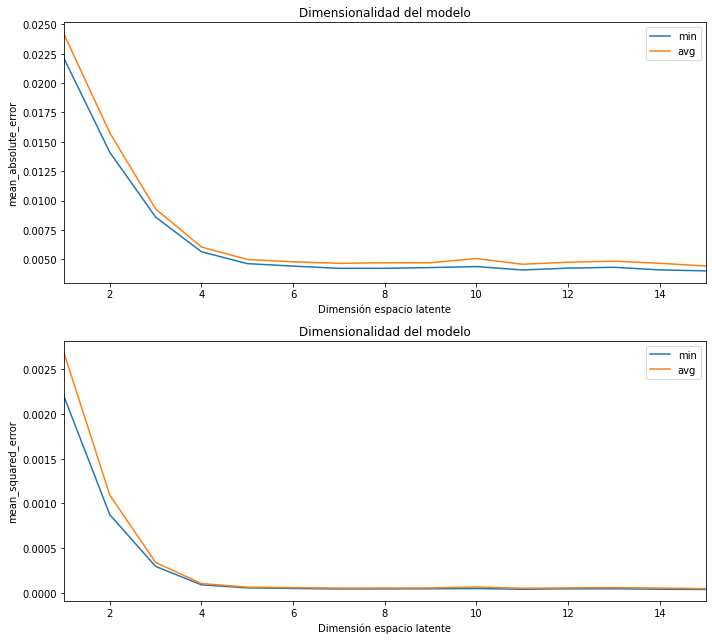

In [28]:
img_name= 'results/costo_SSA_two_layer_2_HH_ngi.png'
img_path = os.path.join('/'.join(folder), img_name)

# Visualizo los errores -  Mean Absolute error
plt.figure(figsize = (10,9))
plt.subplot(2,1,1)
plt.plot(range(1, 16), min_abs_error)
plt.plot(range(1, 16), avg_abs_error)
plt.title('Dimensionalidad del modelo')
plt.ylabel('mean_absolute_error')
plt.xlabel('Dimensión espacio latente')
plt.xlim((1, 15))
plt.legend(['min', 'avg'])
plt.tight_layout()
 

# Mean Squared Error
plt.subplot(2,1,2)
plt.plot(range(1, 16), min_sqr_error)
plt.plot(range(1, 16), avg_sqr_error)
plt.title('Dimensionalidad del modelo')
plt.ylabel('mean_squared_error')
plt.xlabel('Dimensión espacio latente')
plt.xlim((1, 15))
plt.legend(['min', 'avg'])
plt.tight_layout()
plt.savefig(img_path)
plt.show() 

In [29]:
# Guardo los datos
import pickle
cost_dict = {'MSE': (min_sqr_error, avg_sqr_error), 
             'MAE': (min_abs_error, avg_abs_error)}

path = os.path.join('/'.join(folder), 'results/cost_SSA_two_layer_HH.pkl')             

with open(path, 'wb') as f:
  pickle.dump(cost_dict, f)